In [1]:
import psycopg2
import pandas as pd
import numpy as np
from tqdm import tqdm
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from ckonlpy.tag import Twitter
from pykospacing import Spacing

In [27]:
twitter = Twitter()
spacing = Spacing()

#외래어 읽어오기
loanwords = pd.read_csv('loanwords.txt', encoding = 'cp949')
loanwords = loanwords['word'].tolist()
for word in loanwords :
    twitter.add_dictionary(word, 'Noun')

#불용어제거 + 토큰화
keyword = '크롭셔츠'
clean_word = '%'
kospacing_word = spacing(keyword) # 띄워쓰기 보완
tokenized_word = twitter.morphs(kospacing_word) # 토큰화
for tk in tokenized_word :
    clean_word = clean_word + tk + '%'
#tokenized_word
clean_word

c:\Users\User\anaconda3\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


'%크롭%셔츠%'

In [28]:
#postgresql 접속
conn_string = "host='localhost' dbname='postgres' user='postgres' password='admin'"
conn = psycopg2.connect(conn_string)
cur = conn.cursor()

#데이터 가져오기
cur.execute("select distinct title, date, url, hashtag from yt_clothes where title like '" + clean_word + "'")
conn.commit()
data = cur.fetchall()

#DF화
df = pd.DataFrame(data)
df.columns = ['title', 'date', 'url', 'hashtag']

#db 연결 종료
conn.cursor().close()
conn.close()



In [29]:
df.head()

,title,date,url,hashtag
0,(여리핏) 데일리 크롭 골지 티셔츠 3 color,2021-09-28,https://www.youtube.com/shorts/5vcKagq1fVU,
1,[4K] 봄 나들이 룩북 LOOKBOOK | 화이트크롭티셔츠+청미니스커트+테니스스커...,2022-03-25,https://www.youtube.com/watch?v=1b9y2tH93Mk,#룩북 #봄나들이 #스커트 #스타킹 #데이트
2,[Lookbook] 크롭핏(cropped fit) 코디 / 크롭후드 맨투맨 / 크롭...,2022-01-09,https://www.youtube.com/watch?v=WTV0PbMmLx0,
3,[ootd] 데일리룩 #데일리룩 #데일리룩북 #데일리룩브이로그 #크롭자켓코디 #크롭...,2021-11-03,https://www.youtube.com/shorts/xBz0xaoCYHM,#데일리룩 #데일리룩북 #데일리룩브이로그 #크롭자켓코디 #크롭티셔츠코디 #하이웨이스...
4,[ZARA]자라 여름 신상 하울 / 린넨자켓 /린넨원피스/버뮤다팬츠 / 데님 /크롭티셔츠,2022-05-31,https://www.youtube.com/watch?v=fDv262rINuA,


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    28 non-null     object
 1   date     28 non-null     object
 2   url      28 non-null     object
 3   hashtag  28 non-null     object
dtypes: object(4)
memory usage: 1.0+ KB


In [31]:
# 모든 타이틀 제목을 연결해서 하나의 텍스트 문서로 만들려 함
titles = df['title'].tolist()
titles[:5]

['(여리핏) 데일리 크롭 골지 티셔츠 3 color',
 '[4K] 봄 나들이 룩북 LOOKBOOK | 화이트크롭티셔츠+청미니스커트+테니스스커트+H라인스커트+커피색스타킹',
 '[Lookbook] 크롭핏(cropped fit) 코디 / 크롭후드 맨투맨 / 크롭 반팔티셔츠 / 크롭 슬림핏 맨투맨 / 크롭 오버핏 스웨트 티셔츠/ルックブック/why?shirt🌝',
 '[ootd] 데일리룩 #데일리룩 #데일리룩북 #데일리룩브이로그 #크롭자켓코디 #크롭티셔츠코디 #하이웨이스트진 #데일리코디 #데일리룩코디 #그레이자켓코디 #크롭티코디 #shorts',
 '[ZARA]자라 여름 신상 하울 / 린넨자켓 /린넨원피스/버뮤다팬츠 / 데님 /크롭티셔츠']

In [32]:
twitter = Twitter()
spacing = Spacing()

def rmEmoji(inputData):

    emoji_pattern = re.compile("["
        u"\U00010000-\U0010FFFF"  #BMP characters 이외
            "]+", flags=re.UNICODE)

    return emoji_pattern.sub(r'', inputData) # no emoji

#불용어 읽어오기
stopwords = pd.read_csv("stopwords.txt")
stopwords = stopwords['word'].tolist()
stopwords.extend([',', '.', '+', '[', ']', '!', '?', '(', ')', '|', '_', '~', '#', '/'])

#외래어 읽어오기
loanwords = pd.read_csv('loanwords.txt', encoding = 'cp949')
loanwords = loanwords['word'].tolist()
for word in loanwords :
    twitter.add_dictionary(word, 'Noun')

#불용어제거 + 토큰화
tks = []
for sentence in tqdm(titles) :
    reEmoji_sent = rmEmoji(sentence) # 이모티콘 제거
    kospacing_sent = spacing(reEmoji_sent) # 띄워쓰기 보완
    tokenized_sent = twitter.morphs(kospacing_sent) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sent if not word in stopwords] # 불용어 제거
    tks.append(stopwords_removed_sentence)

c:\Users\User\anaconda3\lib\site-packages\konlpy\tag\_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')
100%|██████████| 28/28 [00:02<00:00, 11.10it/s]


In [60]:
clean_sentences = []
for tk in tks :
    clean_sentences.append(" ".join(tk))

replace_sentences = []
for sent in clean_sentences :
    for tk in tokenized_word :
        sent = sent.replace(tk, '')
    replace_sentences.append(sent)
replace_sentences

['여리핏 데일리  골지 티 3 color',
 '4 K 봄 나들이 룩 북 LOOKBOOK 화이트  티 청 미니스커트 테니스 스커트 H 라인 스커트 커피 색 스타킹',
 'Lookbook  핏 cropped fit 코디  후드 맨투맨  반팔 티  슬림핏 맨투맨  오버핏 스웨 트 티 ルックブック why shirt',
 'ootd 데일리 룩 데일리 룩 데일리 룩 북 데일리 룩 브이로그  자켓 코디  티 코디 하이웨이 스트진 데일리 코디 데일리 룩 코디 그레이 자켓 코디  티코 디 #sh orts',
 'ZARA 자라 여름 신상 하울 린넨 자켓 린넨 원피스 버뮤다 팬츠 데님  티',
 '국내 제작 린넨 패드  티 어깨 끈 랩 롱 원피스',
 '숩 니 공 방 코바늘 프릴  티 만들기 강아지 티 고양이 티 dog croc het',
 '패션 하울 COS 세 잘 어울리는 코스 9 가지 여름 추천 템 리넨 점프수트 l 원피스 l 여름 니트 l  원피스 l 쇼츠 l 하이 웨스트 슬랙스 l   l',
 '하루 한 컷 가을 데일리 룩 ㅣ  체크 남방 ㅣ  코디 ㅣ 여자 룩북',
 '2021 청 치마 하나로 가을 데일리 룩 코디 완성  가디건 브라 렛 레이스 가디건 오버핏 스트라이프  #Shorts 비바 소 피',
 '2021년 대세  단가 라 티 !! #shorts apmplace 가을 코디 패션 동대문 도매',
 'Haul 여름 쇼핑 하울 ZARA 자라 핏 예쁜 티   쇼핑몰 추천 랄 프로 렌 반팔 NEW 브랜드 소개 테니스 로망템',
 '드롭숄더 라운드 넥  긴 맨투맨 티',
 '린넨  체크  3 color',
 '린넨  체크  3 color 1',
 '몽실 투 피스  긴 티 H 라인 스커트 3 color',
 '벨벳 타이 트 핏 프릴 포인트 연말 룩  목 폴라 티 5 컬러',
 '숏  긴 체크 카라 블라우스 남방 ',
 '여름 린넨 긴  체크  2 컬러',
 '여름 룩북 NEW IN 옷 11 벌 팬츠 쳐 돌이 여름 데일리 룩 #오오티디 와이드 데님 슬랙스 탑  여름 니트'

In [61]:
# title수 * title수 의 TF-IDF 상관행렬 만들기
n = len(replace_sentences)
text_mat = np.zeros(shape=(n,n), dtype=np.float64)

#TF-IDF
tfidf = TfidfVectorizer(analyzer='word', encoding='utf-8')
tfidf.fit(replace_sentences)

TfidfVectorizer()

In [62]:
tfidf.vocabulary_

{'여리핏': 89,
 '데일리': 39,
 '골지': 29,
 'color': 4,
 '나들이': 32,
 'lookbook': 13,
 '화이트': 141,
 '미니스커트': 55,
 '테니스': 123,
 '스커트': 77,
 '라인': 45,
 '커피': 116,
 '스타킹': 78,
 'cropped': 7,
 'fit': 9,
 '코디': 118,
 '후드': 142,
 '맨투맨': 53,
 '반팔': 56,
 '슬림핏': 82,
 '오버핏': 94,
 '스웨': 76,
 'ルックブック': 23,
 'why': 21,
 'shirt': 18,
 'ootd': 15,
 '브이로그': 63,
 '자켓': 106,
 '하이웨이': 140,
 '스트진': 80,
 '그레이': 31,
 '티코': 125,
 'sh': 17,
 'orts': 16,
 'zara': 22,
 '자라': 104,
 '여름': 87,
 '신상': 84,
 '하울': 138,
 '린넨': 51,
 '원피스': 99,
 '버뮤다': 57,
 '팬츠': 128,
 '데님': 38,
 '국내': 30,
 '제작': 108,
 '패드': 126,
 '어깨': 85,
 '코바늘': 119,
 '프릴': 133,
 '만들기': 52,
 '강아지': 27,
 '고양이': 28,
 'dog': 8,
 'croc': 6,
 'het': 11,
 '패션': 127,
 'cos': 5,
 '어울리는': 86,
 '코스': 120,
 '가지': 26,
 '추천': 112,
 '리넨': 50,
 '점프수트': 107,
 '니트': 35,
 '쇼츠': 70,
 '하이': 139,
 '웨스트': 100,
 '슬랙스': 81,
 '하루': 137,
 '가을': 25,
 '체크': 110,
 '남방': 33,
 '여자': 90,
 '룩북': 49,
 '2021': 1,
 '치마': 113,
 '하나로': 136,
 '완성': 98,
 '가디건': 24,
 '브라': 61,
 '레이스': 46,
 '스트라이프': 

In [63]:
len(replace_sentences)

28

In [64]:
#문장의 모든 순서쌍마다 vector 간의 cosine similarity를 구함
from sklearn.metrics.pairwise import cosine_similarity

for idxi, i in enumerate(replace_sentences) :
    for idxj, j in enumerate(replace_sentences) :
        # row, col이 같으면 스킵
        if idxi == idxj:
            continue
        
        text_mat[idxi][idxj] = cosine_similarity(tfidf.transform([i]), tfidf.transform([j]))[0][0]

text_mat

array([[0.        , 0.        , 0.        , 0.28048102, 0.        ,
        0.        , 0.        , 0.        , 0.12508256, 0.07720405,
        0.        , 0.        , 0.        , 0.23900809, 0.23900809,
        0.14331828, 0.        , 0.        , 0.        , 0.07920175,
        0.        , 0.        , 0.        , 0.19848468, 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.06769037, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.06860347, 0.        , 0.        , 0.        ,
        0.33566221, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.13008091],
       [0.        , 0.06769037, 0.        , 0.07753585, 0.        ,
        0.        , 0.        , 0.        , 0.04149321, 0.08371626,
        0.03245543, 0.04179893, 0.25633264, 0.        , 0.        ,
        0.        , 0.    

In [92]:
# 인접리스트 방식으로 노드 간의 연결관계 표현

mat = text_mat.copy()
output_node = []

for row in mat: # row : 한 title과 다른 title 간의 코사인유사도 array; shape[28,]
    tmp=[]
    for i in range(len(row) ):
        if row[i]>0.1 : # 다른 title과 이루는 내각이 60도 이상이라면
            tmp.append(i)
    output_node.append(tmp)


for i in range(len(output_node)) :
    print(len(output_node[i]), end=' ')

6 2 2 7 10 5 1 8 12 6 3 5 1 10 10 6 3 6 12 10 5 5 10 6 4 0 6 7 

In [93]:
d = 0.85
initial_tr=1/len(mat)
TR = [initial_tr]*len(mat)

TR

[0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571,
 0.03571428571428571]

In [94]:
#while문을 탈출하기 위한 boolean 변수
stop = False

#error 값을 저장하기 위한 변수
history = []
step = 0

while stop == False:
    # A,B,C,D를 업데이트할 때 원래값과 수정된 값의 차이의 합
    #error = S_k+1(V_i) + S_k(V_i)
    total_error = 0
    # A,B,C,D를 순회하면서
    for node in range(len(mat)):
        # 초항 : 1-d
        update_val = (1-d)
        tmp = 0
        # A 노드와 연결된 노드 중에서 (B, D)
        for i in output_node[node] :
            s=0
            # B에 연결된 노드의 가중치 합을 S에 저장
            for j in output_node[i] :
                s+= mat[i][j]
            # TR['B'] * mat[A->B] / sigma(B)
            k=TR[i]*(mat[node][i]/s)
            tmp += k
        # update_val은 기존의 1-d + d*tmp, d=0.85
        update_val +=tmp*d
        # error는 기존값과 update_val의 차이
        error = abs(TR[node] - update_val)
        # total_error에 error를 더해줌
        total_error += error
        TR[node] = update_val
        #만약 error가 e^-10보다 작다면 early stop flag
    if total_error < 1e-10:
        stop = True
    
    history.append(total_error)
    step+=1
    print("step:", step, " error:", total_error)
    if stop == True :
        break

step: 1  error: 6.174256931243304
step: 2  error: 5.302674707744182
step: 3  error: 3.981825046561951
step: 4  error: 2.9161074082436027
step: 5  error: 2.1226488281254285
step: 6  error: 1.5434992195380373
step: 7  error: 1.1220933772326063
step: 8  error: 0.8156754108777896
step: 9  error: 0.5929213915922685
step: 10  error: 0.43099947523579524
step: 11  error: 0.31329883440720124
step: 12  error: 0.2277422965241318
step: 13  error: 0.1655507815069172
step: 14  error: 0.12034302886811044
step: 15  error: 0.08748071797460283
step: 16  error: 0.06359237376902344
step: 17  error: 0.04622731920990114
step: 18  error: 0.033604164771501854
step: 19  error: 0.024428007095575688
step: 20  error: 0.01775756296011105
step: 21  error: 0.012908595071832507
step: 22  error: 0.009383714886028238
step: 23  error: 0.006821357083628243
step: 24  error: 0.004958689084638035
step: 25  error: 0.003604649604772525
step: 26  error: 0.002620349926454102
step: 27  error: 0.0019048271500304859
step: 28  erro

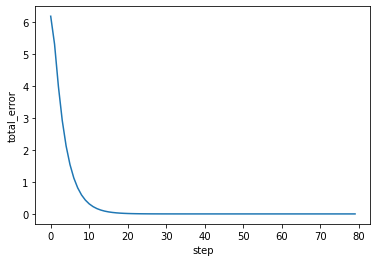

In [95]:
import matplotlib.pyplot as plt
plt.figure.figsize=(10, 10)
plt.ylabel('total_error')
plt.xlabel('step')
plt.plot(history)

In [96]:
# 업데이트된 TR
print(TR)

[0.9011935441138164, 0.46685440339287854, 0.7194440859915922, 1.1190839229505936, 1.527318301776126, 0.6475465702170042, 0.27396790577703056, 0.9986166634518001, 1.5037287940056507, 0.8626484408461624, 0.49943692424162117, 0.6454929141464262, 0.5822183577014787, 2.1318538854066236, 2.1318538854082925, 0.9425249207386546, 0.5819285206008802, 0.8867986633181522, 2.140223682696974, 1.301606063428307, 0.6425744922944034, 0.6051385368337225, 1.4809604038108937, 0.9578185394899225, 0.6538744741082528, 0.15000000000000002, 0.9430966999946482, 0.8521964030266692]


In [90]:
#정렬
ans=[]
for idx, val in enumerate(TR) :
    ans.append((val, idx))

# 내림차순 정렬 & 상위 5개 선택
bot_5 = sorted(ans, reverse=False)[:5]

bot_5

[(0.15000000000000002, 25),
 (0.27396790577703056, 6),
 (0.46685440339287854, 1),
 (0.49943692424162117, 10),
 (0.5819285206008802, 16)]

In [91]:
for idx, i in enumerate(bot_5) :
    print(idx+1, '번째: ', clean_sentences[i[1]], i[0])

1 번째:  크롭 t 셔츠 입은 연예인 최초 는 남자 0.15000000000000002
2 번째:  숩 니 공 방 코바늘 프릴 크롭 티 만들기 강아지 티셔츠 고양이 티셔츠 dog croc het 0.27396790577703056
3 번째:  4 K 봄 나들이 룩 북 LOOKBOOK 화이트 크롭 티셔츠 청 미니스커트 테니스 스커트 H 라인 스커트 커피 색 스타킹 0.46685440339287854
4 번째:  2021년 대세 크롭 단가 라 티셔츠 !! #shorts apmplace 가을 코디 패션 동대문 도매 0.49943692424162117
5 번째:  벨벳 타이 트 핏 프릴 포인트 연말 룩 크롭 목 폴라 티셔츠 5 컬러 0.5819285206008802


In [102]:
df.head()

,title,date,url,hashtag
0,(여리핏) 데일리 크롭 골지 티셔츠 3 color,2021-09-28,https://www.youtube.com/shorts/5vcKagq1fVU,
1,[4K] 봄 나들이 룩북 LOOKBOOK | 화이트크롭티셔츠+청미니스커트+테니스스커...,2022-03-25,https://www.youtube.com/watch?v=1b9y2tH93Mk,#룩북 #봄나들이 #스커트 #스타킹 #데이트
2,[Lookbook] 크롭핏(cropped fit) 코디 / 크롭후드 맨투맨 / 크롭...,2022-01-09,https://www.youtube.com/watch?v=WTV0PbMmLx0,
3,[ootd] 데일리룩 #데일리룩 #데일리룩북 #데일리룩브이로그 #크롭자켓코디 #크롭...,2021-11-03,https://www.youtube.com/shorts/xBz0xaoCYHM,#데일리룩 #데일리룩북 #데일리룩브이로그 #크롭자켓코디 #크롭티셔츠코디 #하이웨이스...
4,[ZARA]자라 여름 신상 하울 / 린넨자켓 /린넨원피스/버뮤다팬츠 / 데님 /크롭티셔츠,2022-05-31,https://www.youtube.com/watch?v=fDv262rINuA,


In [108]:
titles = df['title'].tolist()
for idx, i in enumerate(bot_5) :
    print(idx+1, '번째: ', titles[idx])

1 번째:  (여리핏) 데일리 크롭 골지 티셔츠 3 color
2 번째:  [4K] 봄 나들이 룩북 LOOKBOOK | 화이트크롭티셔츠+청미니스커트+테니스스커트+H라인스커트+커피색스타킹
3 번째:  [Lookbook] 크롭핏(cropped fit) 코디 / 크롭후드 맨투맨 / 크롭 반팔티셔츠 / 크롭 슬림핏 맨투맨 / 크롭 오버핏 스웨트 티셔츠/ルックブック/why?shirt🌝
4 번째:  [ootd] 데일리룩 #데일리룩 #데일리룩북 #데일리룩브이로그 #크롭자켓코디 #크롭티셔츠코디 #하이웨이스트진 #데일리코디 #데일리룩코디 #그레이자켓코디 #크롭티코디 #shorts
5 번째:  [ZARA]자라 여름 신상 하울 / 린넨자켓 /린넨원피스/버뮤다팬츠 / 데님 /크롭티셔츠
